In [1]:
from google.colab import drive # access data in Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
IMAGE_LIB = '/content/gdrive/My Drive/Liver_Segmentation/tinyData/ct/'
MASK_LIB = '/content/gdrive/My Drive/Liver_Segmentation/tinyData/mask/'
weightsPath = '/content/gdrive/My Drive/Liver_Segmentation/Weights/smallModel_128_onlyLiver.h5'
IMG_HEIGHT, IMG_WIDTH = 128, 128
numOfChannels = 1
plots = False
train = True
onlyLiver = True
onlyLesion = False

numOfEpochs = 20
SEED=42

In [0]:
if numOfChannels == 1:
  if onlyLiver is True and onlyLesion is True:
    print("ERROR - cant be only liver AND only lesion")


In [4]:
%matplotlib inline

import os # os specific actions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # image processing
import matplotlib.pyplot as plt # plots
from sklearn.model_selection import train_test_split # machine learning

# deep learning framework
import keras.backend as K
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *

Using TensorFlow backend.


In [0]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png'] # Read all the images

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_GRAYSCALE).astype('int16').astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im)) # Normalization between 0-1
    x_data[i] = im

all_images = [x for x in sorted(os.listdir(MASK_LIB)) if x[-4:] == '.png'] # Read all the images
y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH,numOfChannels), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_GRAYSCALE).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    
    if numOfChannels > 1:
      splitIm = np.zeros((IMG_WIDTH,IMG_HEIGHT,numOfChannels))
      
      if numOfChannels == 2:
        splitIm[:,:,0] = im==127/255  # Liver
        splitIm[:,:,1] = im==1        # Lesion
      elif numOfChannels == 3:
        splitIm[:,:,0] = im==0        # Background
        splitIm[:,:,1] = im==127/255  # Liver
        splitIm[:,:,2] = im==1        # Lesion
      else:
        print("ERROR - Not implemented yet")
      
      y_data[i] = splitIm.copy()
      
    if numOfChannels == 1:
      if onlyLiver is True:
        im[im>0] = 1
      if onlyLesion is True:
        im[im<255] = 0
      y_data[i,:,:,0] = im.copy()
      
    else:
      print("ERROR - Not implemented yet")

if plots is True:
  fig, ax = plt.subplots(1,2, figsize = (8,4))
  plt.axis('off')
  ax[0].imshow(x_data[i], cmap='gray', vmin=0, vmax=1)
  ax[0].grid(False)
  ax[1].imshow(y_data[i,:,:,0], cmap='gray', vmin=0, vmax=1)
  ax[1].grid(False)

In [0]:
if plots is True:
  print("y_data shape is: ", y_data.shape)
  print("x_data shape is: ", x_data.shape)

In [0]:
x_data = x_data[:,:,:,np.newaxis] # Add channel dimension
# y_data = y_data[:,:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2) # Split data to train and validation (from sklearn.model_selection)

In [0]:
# Define data generator that feeds the network with data
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(  # from keras.preprocessing.image - Generate batches of tensor image data with real-time data augmentation
            width_shift_range=0.1, # Built in augmentations
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED) # Same seed for images and masks
    mask_generator = ImageDataGenerator( 
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [0]:
if plots is True:
  image_batch, mask_batch = next(my_generator(x_train, y_train, 7))
  fix, ax = plt.subplots(7,2, figsize=(7,20))
  for i in range(7):
      ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray', vmin=0, vmax=1)
      ax[i,0].grid(False)
      ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray', vmin=0, vmax=1)
      ax[i,1].grid(False)

In [10]:
# Define model

input_layer = Input(shape=x_train.shape[1:]) # Input shape doesn't include number of images in batch (first dimension)

# 1st contraction block ( 512*512*1 -> 256*256*8 )
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)

# 2nd contraction block ( 256*256*8 -> 128*128*16 )
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)

# 3rd contraction block ( 128*128*16 -> 64*64*32 ) 
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)

c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)  # Bottleneck

# 1st expansion block ( 64*64*32 -> 128*128*32 )
l = concatenate([UpSampling2D(size=(2, 2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)

# 2nd expansion block ( 128*128*32 -> 256*256*24 )
l = concatenate([UpSampling2D(size=(2, 2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)

# 3rd expansion block ( 256*256*24 -> 512*512*16 )
l = concatenate([UpSampling2D(size=(2, 2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)

#   Conv2D(filters=8,  kernel_size=(2,2), activation='relu')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)

# output
output_layer = Conv2D(filters=numOfChannels, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)
if plots is True:
  model.summary() # Print model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Define metrics
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)  # K is keras.backend
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
def precision(y_true, y_pred):  # PPV - Positive Predictive Value
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_pred_f) + K.epsilon())
  
def tversky_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    tp = K.sum(y_true_f * y_pred_f) # True positives
    fp = K.sum(y_pred_f) - tp # False positives
    fn = K.sum(y_true_f) - tp # False negatives

    return (tp + K.epsilon()) / (tp + 0.9 * fp + (1 - 0.9) * fn + K.epsilon())

In [0]:
# Define custom loss
def dice_coef_loss():

    def calculate_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    return calculate_loss
  
def tversky_index_loss():
  
    def calculate_loss(y_true, y_pred):
        return -tversky_index(y_true, y_pred)
      
    return calculate_loss

In [0]:
 model.compile(optimizer=Adam(2e-4), loss=dice_coef_loss(), metrics=[dice_coef, precision]) # Compile model with optimizer, loss and metrics

In [0]:
# Define callbacks that act at the end of epoch
weight_saver = ModelCheckpoint(weightsPath, monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)

lr_scd = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

early_stopping = EarlyStopping(monitor='val_dice_coef', mode="max", patience=5)

In [15]:
# Train the model
if train is True:
  hist = model.fit_generator(my_generator(x_train, y_train, 8), # Training data supplied by generator
                             steps_per_epoch = 30, # Number of mini-batches to run in one epoch
                             validation_data = (x_val, y_val), # Validation data
                             epochs=numOfEpochs, verbose=2,
                             callbacks = [weight_saver, early_stopping, lr_scd])

Epoch 1/20
 - 16s - loss: -2.0215e-01 - dice_coef: 0.2022 - precision: 0.1188 - val_loss: -5.4755e-01 - val_dice_coef: 0.5476 - val_precision: 0.4211
Epoch 2/20
 - 15s - loss: -5.8680e-01 - dice_coef: 0.5868 - precision: 0.5162 - val_loss: -7.1824e-01 - val_dice_coef: 0.7182 - val_precision: 0.9341
Epoch 3/20
 - 15s - loss: -7.0570e-01 - dice_coef: 0.7057 - precision: 0.7098 - val_loss: -7.1459e-01 - val_dice_coef: 0.7146 - val_precision: 0.9756
Epoch 4/20
 - 15s - loss: -7.6707e-01 - dice_coef: 0.7671 - precision: 0.8000 - val_loss: -7.8774e-01 - val_dice_coef: 0.7877 - val_precision: 0.9693
Epoch 5/20
 - 15s - loss: -7.8251e-01 - dice_coef: 0.7825 - precision: 0.8144 - val_loss: -8.2442e-01 - val_dice_coef: 0.8244 - val_precision: 0.9604
Epoch 6/20
 - 15s - loss: -7.9118e-01 - dice_coef: 0.7912 - precision: 0.8239 - val_loss: -8.4658e-01 - val_dice_coef: 0.8466 - val_precision: 0.9295
Epoch 7/20
 - 15s - loss: -8.0094e-01 - dice_coef: 0.8009 - precision: 0.8394 - val_loss: -8.1400e-0

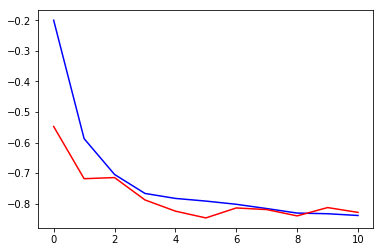

In [16]:
if train is True:
  plt.plot(hist.history['loss'], color='b')
  plt.plot(hist.history['val_loss'], color='r')
  plt.show()
  plt.plot(hist.history['dice_coef'], color='b')
  plt.plot(hist.history['val_dice_coef'], color='r')
  plt.show()

In [0]:
model.load_weights(weightsPath)

In [18]:
fix, ax = plt.subplots(1,1)
ax.grid(False)
ax.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

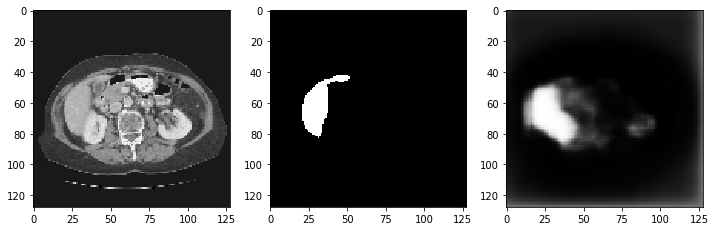

In [19]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[1,:,:,0], cmap='gray')
ax[0].grid(False)
ax[1].imshow(y_val[1,:,:,0], cmap='gray')
ax[1].grid(False)
ax[2].imshow(y_hat[1,:,:,0], cmap='gray')
ax[2].grid(False)

In [20]:
a = y_hat[0,:,:,0]
a = a.flatten()
plt.hist(a, bins=20)
plt.show()

In [34]:
def dice_coef_test(y_true, y_pred):
  epsilon = 0.001
  y_true_f = np.ndarray.flatten(y_true)
  y_pred_f = np.ndarray.flatten(y_pred)
  intersection = np.sum(y_true_f * y_pred_f)
  return (2. * intersection + epsilon) / (np.sum(y_true_f) + np.sum(y_pred_f) + epsilon)

print(dice_coef_test(y_val,y_hat))

6236.5923
0.5475543322737256
